# TEXT LSTM CLASSIFICATION

*Angélica María Gómez Buitrago*

*Juan Camilo Castillo Castro*

In [0]:
|import pandas as pd
import os
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

## Read Data

In [3]:
from google.colab import files
uploaded = files.upload()

Saving dataTesting.csv to dataTesting (1).csv
Saving dataTraining.csv to dataTraining (1).csv


In [4]:
import pandas as pd 
import io
dataTraining = pd.read_csv(io.StringIO(uploaded['dataTraining.csv'].decode('utf-8'))) 
dataTraining.head()

,Unnamed: 0,year,title,plot,genres,rating
0,3107,2003,Most,most is the story of a single father who takes...,"['Short', 'Drama']",8.0
1,900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"['Comedy', 'Crime', 'Horror']",5.6
2,6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","['Drama', 'Film-Noir', 'Thriller']",7.2
3,4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",['Drama'],7.4
4,2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","['Action', 'Crime', 'Thriller']",6.6


In [5]:
dataTraining.shape

(7895, 6)

In [6]:
dataTesting = pd.read_csv(io.StringIO(uploaded['dataTesting.csv'].decode('utf-8'))) 
dataTesting.head()

,Unnamed: 0,year,title,plot
0,1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
1,4,1978,Midnight Express,"the true story of billy hayes , an american c..."
2,5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
3,6,1950,Crisis,husband and wife americans dr . eugene and mr...
4,7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Create y

In [0]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le                     = MultiLabelBinarizer()
y_genres               = le.fit_transform(dataTraining['genres'])

In [8]:
y_genres.shape #Hay 24 categorías de películas

(7895, 24)

# Split train and test

In [0]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(dataTraining['plot'],y_genres, test_size=0.33, random_state=42)

In [10]:
X_train.shape, X_test.shape, y_train_genres.shape, y_test_genres.shape

((5289,), (2606,), (5289, 24), (2606, 24))

# Applying a  LSTM NN

In [0]:
!pip install livelossplot

In [14]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import keras
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, SGD
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

from livelossplot import PlotLossesKeras
%matplotlib inline

['/job:localhost/replica:0/task:0/device:GPU:0']


Using TensorFlow backend.


We use another approach to create the vocabulary: "Tokenizer"

In [0]:
max_words = 10000
max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [0]:
tok.fit_on_texts(X_test)
sequences_test = tok.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences_test,maxlen=max_len)

In [26]:
model = Sequential()

model.add(Embedding(max_words, 32, input_shape=[max_len,]))
model.add(LSTM(100)) #32=neuronas del LSTM
model.add(Dropout(0.2))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(24, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01), metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 32)          320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                6168      
Total params: 405,224
Trainable params: 405,224
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 32)          320000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               25856     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 24)                6168      
Total params: 405,224
Trainable params: 405,224
Non-trainable params: 0
_________________________________________________________________


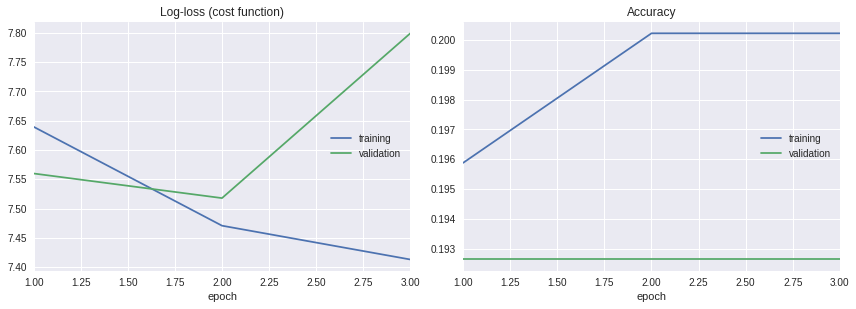

In [28]:
model.fit(sequences_matrix, y_train_genres, validation_data=[sequences_matrix_test, y_test_genres],
          batch_size=128, epochs=3, callbacks=[PlotLossesKeras()])

In [29]:
score = model.evaluate(sequences_matrix_test,y_test_genres)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2606/2606 [==============================] - 44s 17ms/step
Test score: 7.799413586980274
Test accuracy: 0.19263238681112907


In [30]:
roc_auc_score(y_test_genres, model.predict(sequences_matrix_test), average='macro')

0.5416351929307012